## TO DO: 
#### Understand what is the source of the perfect training accuracy: 
* Logistic Regression: play on the C parameter
* RF: play on the parameters that can reduce overfitting
#### Features highly correlated with NHY feature:
* NP3FACXP, NP3FTAPR, NP3HMOVR, NP3PRSPR, NP3TTAPR,NP3POSTR, NP3BRADY,NP2TMPR,NP3SPCH,MSEADLG

## REFERENCES

#### NOTEBOOKS - classic ML
* [DSR- Gerrit- intro to ML] (http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Machine%20Learning%20-%20DSR%20Intro.ipynb)
* [DSR-Gerrit- Boosting & XGBoost]
http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Boosting%20and%20XGBoost.ipynb
* [DSR-Gerrit- RF]
(http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/%20RF%20notebooks/DecisionTrees_Intro.ipynb)
* [DSR-Gerrit-Evaluation models] (http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Evaluation%20Solutions.ipynb)
* [DSR-Gerrit- Bayesian Learning]
(http://localhost:8888/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Bayesian%20Learning%20Solutions.ipynb)
* [DSR-Rachel-ML Pipelines]
(http://localhost:8888/notebooks/00_TRAINING/02_DSR/10_DSR_Model_Pipelines_Rachel/1.3%20Pipelines%20.ipynb)
#### GITHUB repos: 
* **Hands-On Machine Learning w/scikit-learn and TensorFlow book: https://github.com/AMDonati/handson-ml**
* https://github.com/AMDonati/data-science-ipython-notebooks
* Data Science w/ Python handbook: https://github.com/AMDonati/PythonDataScienceHandbook
* https://github.com/AMDonati/machine-learning-cheat-sheet
#### Specific to time-series: 
* https://github.com/ChadFulton/tsa-notebooks
* https://github.com/maxim5/time-series-machine-learning

## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
% matplotlib inline

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#!pip install -U imbalanced-learn

# I. Features importance & Non TS classification of Disease Progression

## 1. Data preparation

### Reading the preprocessed dataframe

In [3]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
df.head()

,PATNO,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,7,2,394,2313,700,0,0
2,3001,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,7,3,426,1887,1126,0,0
3,3001,2014-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,4,335,1552,1461,0,0
4,3001,2015-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,5,365,1187,1826,0,0


In [4]:
#list(df.columns)

### Removing motor and non motor assessments

In [5]:
file_path2='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/PD_Progression_Motor-assessments.csv'
motor_ass=pd.read_csv(file_path2)
motor_ass.drop(columns='Unnamed: 0',inplace=True)
motor_ass.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
Motor_ass_features=list(motor_ass.columns)
motor_ass.head()

,PATNO,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,...,NP3RTCON,DYSKPRES,ON_OFF_DOSE,PD_MED_USE,NP4WDYSK,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN
0,3402,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,3400,0.0,0.0,2.0,3.0,2.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,3403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,3406,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,...,2.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
if 'PATNO' in Motor_ass_features: 
    Motor_ass_features.remove('PATNO')
#Motor_ass_features

In [7]:
file_path3='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/Non-Motor_Assessments.csv'
NonMotor_ass=pd.read_csv(file_path3)
NonMotor_ass.drop(columns='Unnamed: 0',inplace=True)
NonMotor_ass.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
NonMotor_ass_features=list(NonMotor_ass.columns)
NonMotor_ass.head()

,PATNO,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,LNS_TOTRAW,...,CNTRLGMB,TMSEX,CNTRLSEX,TMBUY,CNTRLBUY,TMEAT,CNTRLEAT,TMTORACT,TMTMTACT,TMTRWD
0,3102,3.0,2.0,1.0,2.0,3.0,1.0,1.0,1.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3630,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3404,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3428,1.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
if 'PATNO' in NonMotor_ass_features: 
    NonMotor_ass_features.remove('PATNO')
NonMotor_ass_features

['ESS1',
 'ESS2',
 'ESS3',
 'ESS4',
 'ESS5',
 'ESS6',
 'ESS7',
 'ESS8',
 'LNS_TOTRAW',
 'AGE_ASSESS_LNS',
 'DVS_LNS',
 'DRMVIVID',
 'DRMAGRAC',
 'DRMNOCTB',
 'SLPLMBMV',
 'SLPINJUR',
 'DRMVERBL',
 'DRMFIGHT',
 'DRMUMV',
 'DRMOBJFL',
 'MVAWAKEN',
 'DRMREMEM',
 'SLPDSTRB',
 'STROKE',
 'HETRA',
 'PARKISM',
 'RLS',
 'NARCLPSY',
 'DEPRS',
 'EPILEPSY',
 'BRNINFM',
 'SCAU1',
 'SCAU2',
 'SCAU3',
 'SCAU4',
 'SCAU5',
 'SCAU6',
 'SCAU7',
 'SCAU8',
 'SCAU9',
 'SCAU10',
 'SCAU11',
 'SCAU12',
 'SCAU13',
 'SCAU14',
 'SCAU15',
 'SCAU16',
 'SCAU17',
 'SCAU18',
 'SCAU19',
 'SCAU20',
 'SCAU21',
 'SCAU26B',
 'SCAU26C',
 'SCAU26D',
 'COGDECLN',
 'FNCDTCOG',
 'COGSTATE',
 'COGDXCL',
 'RVWNPSY',
 'HVLTRT1',
 'HVLTRT2',
 'HVLTRT3',
 'HVLTRDLY',
 'HVLTREC',
 'HVLTFPRL',
 'HVLTFPUN',
 'HVLTVRSN',
 'DVT_TOTAL_RECALL',
 'DVT_DELAYED_RECALL',
 'DVT_RETENTION',
 'DVT_RECOG_DISC_INDEX',
 'MCAALTTM',
 'MCACUBE',
 'MCACLCKC',
 'MCACLCKN',
 'MCACLCKH',
 'MCALION',
 'MCARHINO',
 'MCACAMEL',
 'MCAFDS',
 'MCABDS',
 'MCAVI

In [9]:
df_truncated=df.drop(columns=Motor_ass_features)
df_truncated.drop(columns=NonMotor_ass_features,inplace=True)
df_truncated.drop(columns=['MSEADLG'],inplace=True)
df_truncated.set_index(keys=['PATNO','INFODT_date'],inplace=True)
print('number of features:{}'.format(len(df_truncated.columns)))
df_truncated.head()

number of features:142


NHY  PDMEDYN  ONLDOPA  ONDOPAG  ONOTHER  FULNUPDR  PDSURG  \
PATNO INFODT_date                                                              
3001  2011-02-01   2.0      0.0      0.0      0.0      0.0       0.0     0.0   
      2012-03-01   2.0      0.0      0.0      0.0      0.0       1.0     0.0   
      2013-05-01   2.0      1.0      0.0      0.0      1.0       0.0     0.0   
      2014-04-01   2.0      1.0      0.0      1.0      1.0       0.0     0.0   
      2015-04-01   2.0      1.0      1.0      0.0      1.0       1.0     0.0   

                   PDSURGTP  MSRARSP  MSLARSP         ...          DXPOSINS  \
PATNO INFODT_date                                     ...                     
3001  2011-02-01        4.0      0.0      0.0         ...                 0   
      2012-03-01        4.0      0.0      0.0         ...                 0   
      2013-05-01        4.0      0.0      0.0         ...                 0   
      2014-04-01        4.0      0.0      0.0         ...                 0   
      2015-04-01        4.0      0.0      0.0         ...                 0   

                   DXOTHSX  DOMSIDE  num_visits  VISIT_ID  visitsdiff_days  \
PATNO INFODT_date                                                            
3001  2011-02-01         0        2           7         1                0   
      2012-03-01         0        2           7         2              394   
      2013-05-01         0        2           7         3              426   
      2014-04-01         0        2           7         4              335   
      2015-04-01         0        2           7         5              365   

                   lastDate_diff_days  PDDXDT_diff_days  PDMEDT_diff_days  \
PATNO INFODT_date                                                           
3001  2011-02-01                 2707               306                 0   
      2012-03-01                 2313               700                 0   
      2013-05-01                 1887              1126                 0   
      2014-04-01                 1552              1461                 0   
      2015-04-01                 1187              1826                 0   

                   PDSURGDT_diff_days  
PATNO INFODT_date                      
3001  2011-02-01                    0  
      2012-03-01                    0  
      2013-05-01                    0  
      2014-04-01                    0  
      2015-04-01                    0  

[5 rows x 142 columns]

In [10]:
df_truncated['NHY'].value_counts()

2.0    2386
0.0    1227
1.0     865
3.0     246
4.0      47
5.0      13
Name: NHY, dtype: int64

## 2. Split train, test

In [11]:
from sklearn.model_selection import train_test_split

data=df_truncated.drop(columns='NHY')
target=df_truncated['NHY']
train, test = train_test_split(df_truncated, test_size=0.3, random_state=0)

train.to_pickle("./train_nonTS.pickle")
test.to_pickle("./test_nonTS.pickle")
print('train counts: {}'.format(train.NHY.value_counts()))

X_train = train.loc[:,train.columns!='NHY']
y_train = train['NHY']
X_test = test.loc[:,train.columns!='NHY']
y_test = test[('NHY')]
print(X_train.shape)
print('test counts: {}'.format(y_test.value_counts()))

train.head()

train counts: 2.0    1671
0.0     842
1.0     617
3.0     173
4.0      37
5.0       8
Name: NHY, dtype: int64
(3348, 141)
test counts: 2.0    715
0.0    385
1.0    248
3.0     73
4.0     10
5.0      5
Name: NHY, dtype: int64


,,NHY,PDMEDYN,ONLDOPA,ONDOPAG,ONOTHER,FULNUPDR,PDSURG,PDSURGTP,MSRARSP,MSLARSP,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,INFODT_date,,,,,,,,,,,,,,,,,,,,,
40574,2016-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,0,0,3,2,759,852,0,0,0
4034,2018-04-01,2.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,1,2,6,6,396,91,2800,0,0
3373,2015-06-01,2.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,1,2,6,4,335,1126,1247,0,0
42454,2016-12-01,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,1,1,2,1,0,577,2253,0,0
3415,2016-03-01,2.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,...,0,0,2,8,6,366,852,1886,0,0


### Take care of the classes unbalance with a sample upsampling

In [12]:
from sklearn.utils import resample

def upsampling_NHY(train):
    train_majority = train[train.NHY==2.0]
    train_minority_1 = train[train.NHY==1.0]
    train_minority_0= train[train.NHY==0.0]
    train_minority_3= train[train.NHY==3.0]
    train_minority_4=train[train.NHY==4.0]
    train_minority_5=train[train.NHY==5.0]

    # Upsample minority class
    train_minority_upsampled_1 = resample(train_minority_1, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_0 = resample(train_minority_0, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_3 = resample(train_minority_3, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_4= resample(train_minority_4, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results
    train_minority_upsampled_5= resample(train_minority_5, 
                                     replace=True,     # sample with replacement
                                     n_samples=train_majority.shape[0],  # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    train_upsampled = pd.concat([train_majority, train_minority_upsampled_1,train_minority_upsampled_0,
                                 train_minority_upsampled_3,train_minority_upsampled_4,
                                 train_minority_upsampled_5])

    # Show new class counts
    print(train_upsampled.NHY.value_counts())
    
    return train_upsampled

train_upsampled=upsampling_NHY(train)

5.0    1671
4.0    1671
3.0    1671
0.0    1671
1.0    1671
2.0    1671
Name: NHY, dtype: int64


In [13]:
X_train_up = train_upsampled.loc[:,train.columns!='NHY']
y_train_up= train_upsampled['NHY']
data_up=upsampling_NHY(df_truncated)
target_up=data_up['NHY']
data_up.drop(columns='NHY',inplace=True)

assert len(data_up)==len(target_up)

5.0    2386
4.0    2386
3.0    2386
0.0    2386
1.0    2386
2.0    2386
Name: NHY, dtype: int64


In [14]:
data_up.head()

PDMEDYN  ONLDOPA  ONDOPAG  ONOTHER  FULNUPDR  PDSURG  \
PATNO INFODT_date                                                         
3001  2011-02-01       0.0      0.0      0.0      0.0       0.0     0.0   
      2012-03-01       0.0      0.0      0.0      0.0       1.0     0.0   
      2013-05-01       1.0      0.0      0.0      1.0       0.0     0.0   
      2014-04-01       1.0      0.0      1.0      1.0       0.0     0.0   
      2015-04-01       1.0      1.0      0.0      1.0       1.0     0.0   

                   PDSURGTP  MSRARSP  MSLARSP  MSRLRSP         ...          \
PATNO INFODT_date                                              ...           
3001  2011-02-01        4.0      0.0      0.0      0.0         ...           
      2012-03-01        4.0      0.0      0.0      0.0         ...           
      2013-05-01        4.0      0.0      0.0      0.0         ...           
      2014-04-01        4.0      0.0      0.0      0.0         ...           
      2015-04-01        4.0      0.0      0.0      0.0         ...           

                   DXPOSINS  DXOTHSX  DOMSIDE  num_visits  VISIT_ID  \
PATNO INFODT_date                                                     
3001  2011-02-01          0        0        2           7         1   
      2012-03-01          0        0        2           7         2   
      2013-05-01          0        0        2           7         3   
      2014-04-01          0        0        2           7         4   
      2015-04-01          0        0        2           7         5   

                   visitsdiff_days  lastDate_diff_days  PDDXDT_diff_days  \
PATNO INFODT_date                                                          
3001  2011-02-01                 0                2707               306   
      2012-03-01               394                2313               700   
      2013-05-01               426                1887              1126   
      2014-04-01               335                1552              1461   
      2015-04-01               365                1187              1826   

                   PDMEDT_diff_days  PDSURGDT_diff_days  
PATNO INFODT_date                                        
3001  2011-02-01                  0                   0  
      2012-03-01                  0                   0  
      2013-05-01                  0                   0  
      2014-04-01                  0                   0  
      2015-04-01                  0                   0  

[5 rows x 141 columns]

In [15]:
target_up.head()

PATNO  INFODT_date
3001   2011-02-01     2.0
       2012-03-01     2.0
       2013-05-01     2.0
       2014-04-01     2.0
       2015-04-01     2.0
Name: NHY, dtype: float64

from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
X_resampled.shape
logreg_smote = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)

In [16]:
#X_resampled, y_resampled = ADASYN().fit_sample(X, y)
#clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

## 3. Model Training

### Dummy Classifier

In [17]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [18]:
print("Train-Score: %.4f, Test-Accuracy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score: 0.3417, Test-Accuracy: 0.3698


### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

#### with upsampling

In [20]:
logreg_up=LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=1)
logreg_up.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Random Forest

In [21]:
rfc_up = RandomForestClassifier(n_estimators=100, random_state=1)
rfc_up.fit(X_train_up, y_train_up)

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

dict_weight={'0.0':0.4, '2.0':0.4, '1.0':0.4/3, '3.0':0.4/9, '4.0':0.4/27, '5.0':0.4/(27*8)}
rfc_weighted = RandomForestClassifier(n_estimators=100, random_state=1,class_weight='balanced')
rfc_weighted.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [22]:
#for estimator in rfc.estimators_:
    #print(estimator.tree_.max_depth)
np.mean([estimator.tree_.max_depth for estimator in rfc.estimators_])

30.16

In [23]:
0.4*2+0.4/3+0.4/9+0.4/27+0.4/(8*27)

0.9944444444444445

In [24]:
0.4/3

0.13333333333333333

### XGBoost

In [25]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs=-1,seed=0)
xgb.fit(X_train, y_train)
xgb_up=XGBClassifier(n_jobs=-1,seed=0)
xgb_up.fit(X_train_up, y_train_up)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

## 4. Evaluation: Calculating, plotting metrics

In [26]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg.score(X_train, y_train), 
                                                                logreg.score(X_test, y_test)))
print("Train-Score-logreg-up: %.4f, Test-Accuracy-logreg-up: %.4f" % (logreg_up.score(X_train_up, y_train_up), 
                                                                      logreg_up.score(X_test, y_test)))
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc.score(X_train, y_train), rfc.score(X_test, y_test)))
print("Train-Score-rfc-up: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_up.score(X_train_up, y_train_up), 
                                                             rfc_up.score(X_test, y_test)))
print("Train-Score-rfc-weighted: %.4f, Test-Accuracy-weighted: %.4f" % (rfc_weighted.score(X_train, y_train), 
                                                             rfc_weighted.score(X_test, y_test)))

print("Train-Score-xgb: %.4f, Test-Accuracy-xgb: %.4f" % (xgb.score(X_train, y_train), 
                                                         xgb.score(X_test, y_test)))
print("Train-Score-xgb-up: %.4f, Test-Accuracy-xgb-up: %.4f" % (xgb_up.score(X_train_up, y_train_up), 
                                                         xgb_up.score(X_test, y_test)))

Train-Score-logreg: 0.7873, Test-Accuracy-logreg: 0.7514
Train-Score-logreg-up: 0.8231, Test-Accuracy-logreg-up: 0.6379
Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.7765
Train-Score-rfc-up: 1.0000, Test-Accuracy-rfc: 0.7744
Train-Score-rfc-weighted: 1.0000, Test-Accuracy-weighted: 0.7660
Train-Score-xgb: 0.8253, Test-Accuracy-xgb: 0.7639
Train-Score-xgb-up: 0.8864, Test-Accuracy-xgb-up: 0.6657


### Confusion Matrix

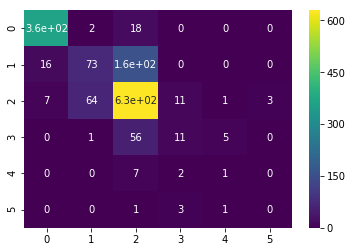

In [27]:
y_pred_logreg=logreg.predict(X_test)
cm_logreg=confusion_matrix(y_test,y_pred_logreg)
cm_logreg_df=pd.DataFrame(cm_logreg,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
import seaborn as sns
sns.heatmap(cm_logreg_df,annot=True,cmap='viridis')

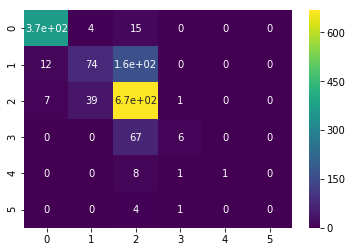

In [28]:
y_pred_rfc=rfc.predict(X_test)
cm_rfc=confusion_matrix(y_test,y_pred_rfc)
cm_rfc_df=pd.DataFrame(cm_rfc,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
sns.heatmap(cm_rfc_df,annot=True,cmap='viridis')

### classification report

In [29]:
from sklearn.metrics import classification_report
report_logreg = classification_report(y_test, 
                      y_pred_logreg)
print(report_logreg)

             precision    recall  f1-score   support

        0.0       0.94      0.95      0.94       385
        1.0       0.52      0.29      0.38       248
        2.0       0.72      0.88      0.79       715
        3.0       0.41      0.15      0.22        73
        4.0       0.12      0.10      0.11        10
        5.0       0.00      0.00      0.00         5

avg / total       0.72      0.75      0.73      1436



In [30]:
report_rfc = classification_report(y_test, 
                      y_pred_rfc)
print(report_rfc)

             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95       385
        1.0       0.63      0.30      0.41       248
        2.0       0.72      0.93      0.82       715
        3.0       0.67      0.08      0.15        73
        4.0       1.00      0.10      0.18        10
        5.0       0.00      0.00      0.00         5

avg / total       0.76      0.78      0.74      1436



/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
y_pred_rfc_up=rfc_up.predict(X_test)
report_rfc_up = classification_report(y_test, 
                      y_pred_rfc_up)
print(report_rfc_up)

             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95       385
        1.0       0.58      0.38      0.45       248
        2.0       0.74      0.90      0.81       715
        3.0       0.50      0.10      0.16        73
        4.0       1.00      0.10      0.18        10
        5.0       0.00      0.00      0.00         5

avg / total       0.75      0.77      0.75      1436



/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 5. Cross-Validation

In [32]:
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
#cv_score_logreg=cross_val_score(logreg,data,target,cv=3,n_jobs=-1)
#print(cv_score_logreg)
#print(cv_score_logreg.mean())
# C = 1/lambda, the parameter of the sigmoid function
# lambda = 0.001, 0.005, 0.01, 0.05, ..., 1, 5, 10, 50

In [33]:
cross_validate_rfc=cross_validate(rfc,data,target,cv=3,n_jobs=-1,return_train_score=True)
cross_validate_xgb=cross_validate(xgb,data,target,cv=3,n_jobs=-1,return_train_score=True)
cross_validate_lr=cross_validate(logreg,data,target,cv=3,n_jobs=-1,return_train_score=True)
cross_validate_rfc_up=cross_validate(rfc_up,data_up,target_up,cv=3,n_jobs=-1,return_train_score=True)
cross_validate_xgb_up=cross_validate(xgb_up,data_up,target_up,cv=3,n_jobs=-1,return_train_score=True)
cross_validate_lr_up=cross_validate(logreg_up,data_up,target_up,cv=3,n_jobs=-1,return_train_score=True)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-pa

In [34]:
#print(cross_validate_lr)
print("Training Accuracy LR: %0.2f (+/- %0.2f)" % (cross_validate_lr['train_score'].mean(), cross_validate_lr['train_score'].std() * 2))
print("Training Accuracy RF: %0.2f (+/- %0.2f)" % (cross_validate_rfc['train_score'].mean(), cross_validate_rfc['train_score'].std() * 2))
print("Training Accuracy XGB: %0.2f (+/- %0.2f)" % (cross_validate_xgb['train_score'].mean(), cross_validate_xgb['train_score'].std() * 2))

print("Test Accuracy LR: %0.2f (+/- %0.2f)" % (cross_validate_lr['test_score'].mean(), cross_validate_lr['test_score'].std() * 2))
print("Test Accuracy RF: %0.2f (+/- %0.2f)" % (cross_validate_rfc['test_score'].mean(), cross_validate_rfc['test_score'].std() * 2))
print("Test Accuracy XGB: %0.2f (+/- %0.2f)" % (cross_validate_xgb['test_score'].mean(), cross_validate_xgb['test_score'].std() * 2))

Training Accuracy LR: 0.80 (+/- 0.02)
Training Accuracy RF: 1.00 (+/- 0.00)
Training Accuracy XGB: 0.84 (+/- 0.01)
Test Accuracy LR: 0.61 (+/- 0.27)
Test Accuracy RF: 0.64 (+/- 0.29)
Test Accuracy XGB: 0.63 (+/- 0.28)


In [35]:
#print(cross_validate_lr)
print("Training Accuracy LR upsampled: %0.2f (+/- %0.2f)" % (cross_validate_lr_up['train_score'].mean(), cross_validate_lr_up['train_score'].std() * 2))
print("Training Accuracy RF upsampled: %0.2f (+/- %0.2f)" % (cross_validate_rfc_up['train_score'].mean(), cross_validate_rfc_up['train_score'].std() * 2))
print("Training Accuracy XGB upsampled: %0.2f (+/- %0.2f)" % (cross_validate_xgb_up['train_score'].mean(), cross_validate_xgb_up['train_score'].std() * 2))

print("Test Accuracy LR upsampled: %0.2f (+/- %0.2f)" % (cross_validate_lr_up['test_score'].mean(), cross_validate_lr_up['test_score'].std() * 2))
print("Test Accuracy RF upsampled: %0.2f (+/- %0.2f)" % (cross_validate_rfc_up['test_score'].mean(), cross_validate_rfc_up['test_score'].std() * 2))
print("Test Accuracy XGB upsampled: %0.2f (+/- %0.2f)" % (cross_validate_xgb_up['test_score'].mean(), cross_validate_xgb_up['test_score'].std() * 2))

Training Accuracy LR upsampled: 0.80 (+/- 0.03)
Training Accuracy RF upsampled: 1.00 (+/- 0.00)
Training Accuracy XGB upsampled: 0.88 (+/- 0.02)
Test Accuracy LR upsampled: 0.74 (+/- 0.04)
Test Accuracy RF upsampled: 0.90 (+/- 0.07)
Test Accuracy XGB upsampled: 0.80 (+/- 0.05)


### feature importance

In [36]:
feature_importances = pd.DataFrame(rfc_up.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures=feature_importances[feature_importances.values>=0.01]
RelevantFeatures=feature_importances[feature_importances.values>0]
RelevantFeaturesList=list(RelevantFeatures.index)
print(sum(ImportantFeatures.values))
print(len(RelevantFeatures)/len(feature_importances))
ImportantFeatures

[0.76434728]
0.9078014184397163


,importance
PDDXDT_diff_days,0.083899
BIRTHDT,0.038845
lastDate_diff_days,0.037973
PRIMDIAG,0.031572
SYSSTND,0.030584
DOMSIDE,0.029472
DIASTND,0.028454
HRSTND,0.028355
visitsdiff_days,0.028215
DIASUP,0.027865


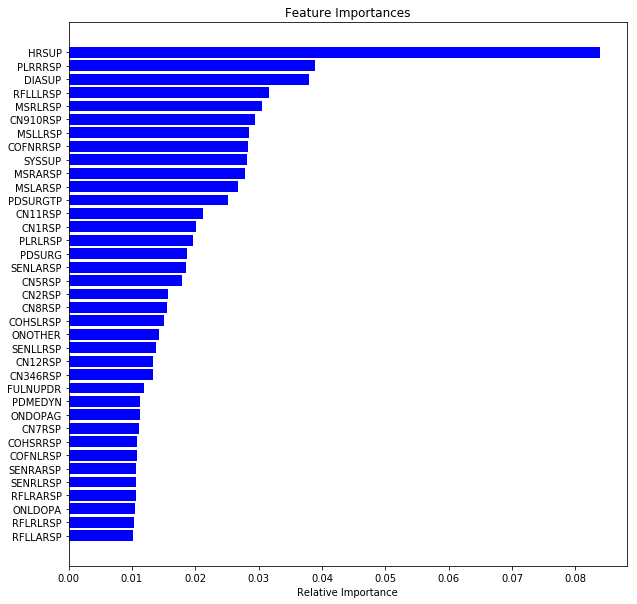

In [39]:
def plot_importantFeatures(clf,X_train,threshold=0.01,figsize=(10,10),color='b'):
    importances=clf.feature_importances_
    importances=importances[importances>=threshold]
    features = X_train.columns
    indices = np.argsort(importances)
    fig = plt.figure(figsize=figsize)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color=color, align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_importantFeatures(rfc_up,X_train_up) #to correct - not consistent with table above

## 6. Hyperparameter tuning with GridSearchCV

#### Using only the Relevant Features from the feature importance

In [40]:
data_GS=data[RelevantFeaturesList]
data_GS.head()

PDDXDT_diff_days  BIRTHDT  lastDate_diff_days  PRIMDIAG  \
PATNO INFODT_date                                                            
3001  2011-02-01                306   1946.0                2707       1.0   
      2012-03-01                700   1946.0                2313       1.0   
      2013-05-01               1126   1946.0                1887       1.0   
      2014-04-01               1461   1946.0                1552       1.0   
      2015-04-01               1826   1946.0                1187       1.0   

                   SYSSTND  DOMSIDE  DIASTND  HRSTND  visitsdiff_days  DIASUP  \
PATNO INFODT_date                                                               
3001  2011-02-01     136.0        2     90.0    72.0                0    90.0   
      2012-03-01     124.0        2     79.0    76.0              394    83.0   
      2013-05-01     104.0        2     85.0    88.0              426    72.0   
      2014-04-01     107.0        2     76.0    82.0              335    68.0   
      2015-04-01     114.0        2     78.0    84.0              365    81.0   

                     ...     MHROW_7  PDMEDT_diff_days  DFAGESX  PESEQ_11  \
PATNO INFODT_date    ...                                                    
3001  2011-02-01     ...           0                 0      0.0         1   
      2012-03-01     ...           0                 0      0.0         1   
      2013-05-01     ...           0                 0      0.0         1   
      2014-04-01     ...           0                 0      0.0         1   
      2015-04-01     ...           0                 0      0.0         1   

                   MHROW_9  MHROW_11  MHROW_8  MHROW_10  PESEQ_13  MHROW_13  
PATNO INFODT_date                                                            
3001  2011-02-01         0         0        0         0         0         0  
      2012-03-01         0         0        0         0         0         0  
      2013-05-01         0         0        0         0         0         0  
      2014-04-01         0         0        0         0         0         0  
      2015-04-01         0         0        0         0         0         0  

[5 rows x 128 columns]

In [41]:
np.mean([estimator.tree_.max_depth for estimator in rfc_up.estimators_])

32.16

In [36]:
def grid_search(param_grid, estimator, data, target, cv=3,njobs=-1):
    from sklearn.model_selection import GridSearchCV
    est = estimator
    grid_search=GridSearchCV(est, param_grid,cv=cv)
    grid_search.fit(data,target)
    print("Best estimator:\n{}".format(grid_search.best_estimator_))
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    return grid_search


#param_grid_rfc={'n_estimators':[10,15,20],
               #'max_features':[10,50,100],
               #'max_leaf_nodes':[None,25,50,100]}
#grid_search=GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid_rfc,cv=5)

#### with no upsampling

In [ ]:
param_grid_rfc={'n_estimators':[500],
               'max_features':[10,20,30],
               'max_depth':[None,5,15]}
grid_search2=grid_search(param_grid_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search2.cv_results_

param_grid3_rfc={'n_estimators':[500,1000],
               'max_features':[15,20,25,30],
               'max_depth':[None,10,15,20]}
grid_search3=grid_search(param_grid3_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search3.cv_results_

# it seems that the overfitting can be really reduced by playing on max_depth: remove None option
param_grid4_rfc={'n_estimators':[500,1000],
               'max_features':[20,30,40],
               'max_depth':[5,10,15]}
grid_search4=grid_search(param_grid4_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search4.cv_results_

param_grid5_rfc={'n_estimators':[1000],
               'max_features':[5,10,15,20],
               'max_depth':[5,7,10]}
grid_search5=grid_search(param_grid5_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target)

#grid_search5.cv_results_

#### with upsampling

In [ ]:
param_grid_rfc={'n_estimators':[500],
               'max_features':[10,20,30],
               'max_depth':[None,5,15]}
grid_search2_up=grid_search(param_grid_rfc, estimator=RandomForestClassifier(random_state=0), 
                        data=data_upsampled_GS, 
                         target=target_upsampled)

#grid_search2_up.cv_results_

param_grid3_rfc={'n_estimators':[500,1000],
               'max_features':[15,20,25,30],
               'max_depth':[None,10,15,20]}
grid_search3_up=grid_search(param_grid3_rfc, estimator=RandomForestClassifier(random_state=0), 
                         data=data_upsampled_GS, 
                         target=target_upsampled)

#grid_search3_up.cv_results_

# it seems that the overfitting can be really reduced by playing on max_depth: remove None option
param_grid4_rfc={'n_estimators':[500,1000],
               'max_features':[20,30,40],
               'max_depth':[5,10,15]}
grid_search4_up=grid_search(param_grid4_rfc, estimator=RandomForestClassifier(random_state=0), 
                            data=data_upsampled_GS, 
                            target=target_upsampled)

#grid_search4_up.cv_results_

param_grid5_rfc={'n_estimators':[1000],
               'max_features':[5,10,15,20],
               'max_depth':[5,7,10]}
grid_search5_up=grid_search(param_grid5_rfc, estimator=RandomForestClassifier(random_state=0), 
                            data=data_upsampled_GS, 
                            target=target_upsampled)

#grid_search5_up.cv_results_

In [37]:
#grid_search5_up.cv_results_